In [11]:
import sys
sys.path.append('./qdarts')

from qdarts.experiment import Experiment
from qdarts.plotting import plot_polytopes

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import utilities.config as c
import utilities.utils  as u
import utilities.model_utils  as mu

In [ ]:
try:
    with h5py.File(path, 'r') as f:
        print("Number of dps in the file:", len(list(f.keys())))
        a_group_key = list(f.keys())[0]
        print(list(f.keys())[0])

except KeyError:
    print("Check the name of the folders under datasets!")
except IOError:
    print("Error opening file...")

In [4]:
import numpy as np
import utilities as u
import h5py
# 19, 8596500959.png
# 10, 2650776797.png
# 19, 0455433572.png
hf = h5py.File(u.get_path_hfd5(2,19), 'r')
hf[list(hf.keys())[0]]

AttributeError: module 'utilities' has no attribute 'get_path_hfd5'

In [2]:
print(len(hf.keys()))

500


In [3]:
hf[list(hf.keys())[0]]['csd'] #x_vol, y_vol, csd

<HDF5 dataset "csd": shape (4, 256, 256), type "|u1">

<PIL.Image.Image image mode=RGBA size=256x256 at 0x1CE890E9940>
C_DD matrix:
[[2.27725074 1.02094747]
 [1.02094747 2.48078009]]

C_DG matrix:
[[2.58967132 1.03803372]
 [0.91469233 2.69178513]]


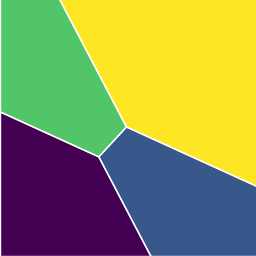

In [5]:
u.reconstruct_img_with_matrices(21,"0763205068.png", True)[0]

<PIL.Image.Image image mode=RGBA size=256x256 at 0x1CEA4198760>
C_DD matrix:
[[ 5.34425699  0.97015584]
 [ 0.97015584 10.17459775]]

C_DG matrix:
[[3.22404238 0.84888027]
 [0.57454912 5.70336887]]


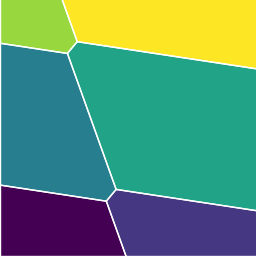

In [4]:
u.reconstruct_img_with_matrices(42,'0135834726.png', True)[0]

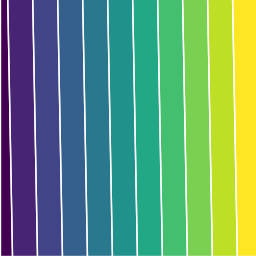

In [7]:
u.load_csd_img(2,10,'2650776797.png')

In [5]:
def count_groups_per_dataset(group):
    group_count = 0
    dataset_count = 0
    for name, item in group.items():
        if isinstance(item, h5py.Group):  # If it's a group, count it and go deeper
            group_count += 1
            sub_group_count, sub_dataset_count = count_groups_per_dataset(item)
            group_count += sub_group_count
            dataset_count += sub_dataset_count
        elif isinstance(item, h5py.Dataset):  # If it's a dataset, count it
            dataset_count += 1
    return group_count, dataset_count

with h5py.File(u.get_path_hfd5(2,20), 'r') as f:
    group_counts = {}
    for name, item in f.items():
        if isinstance(item, h5py.Group):  # If it's a group, process it
            group_count, dataset_count = count_groups_per_dataset(item)
            group_counts[name] = {
                "groups": group_count,
                "datasets": dataset_count
            }

    # Print the result for each top-level group
    for group_name, counts in group_counts.items():
        print(f"Group '{group_name}' contains {counts['groups']} groups and {counts['datasets']} datasets.")


AttributeError: module 'utilities' has no attribute 'get_path_hfd5'

In [14]:
import numpy as np
K=4

vec = np.eye(K).reshape(K,-1).T     

### Data preprocessing

In [1]:
import numpy as np

import utilities.model_utils as mu
import utilities.utils as u
import utilities.config as c

# datapoints = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'], all_batches=False, batches=[1,2])
# datapoints = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'], all_batches=False, batches=[47,48,49])

datapoints = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'])
# datapoints = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'], all_batches=False, batches=np.arange(20,61))

print(f"The amount of datapoints loaded: {len(datapoints)}.")
print(f"The shape of CSD {datapoints[0][0].shape}, and its type {type(datapoints[0][0])}.")

The amount of datapoints loaded: 13500.
The shape of CSD (4, 96, 96), and its type <class 'numpy.ndarray'>.


#### Reconstructed image from saved np.ndarray

In [2]:
example = datapoints[19] # 67, 19

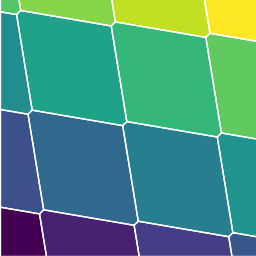

In [3]:
example_csd = example[0]
u.reconstruct_img_from_tensor(example_csd)

#### The preprocessed input seen by the model

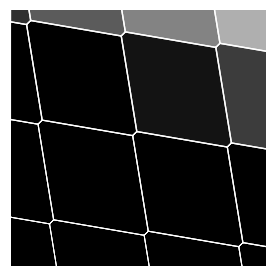

In [4]:
%matplotlib inline

tensor = mu.preprocess_csd(example_csd)
mu.show_image_from_tensor(tensor)

#### Output preproccess

In [5]:
c_dd, c_dg = example[1], example[2]
print(f"C_DD: \n {c_dd}\n")
print(f"C_DG: \n {c_dg}")

C_DD: 
 [[8.95026533 0.96248721]
 [0.96248721 8.30823381]]

C_DG: 
 [[8.79026483 1.01092358]
 [1.00579923 8.34590431]]


In [6]:
# output -> a vector -> row by row first from C_DD, then C_DG -> K*(K+1)/2 + K^2 (elements)
#   
output = mu.preprocess_capacitance_matrices(c_dd, c_dg)
assert len(output) == c.K*(c.K+1)//2 + c.K**2

print(output) 

[8.95026533 0.96248721 8.30823381 8.79026483 1.01092358 1.00579923
 8.34590431]


#### Filter dataset

In [2]:
unfiltered_datapoints = datapoints.copy()
filtred_datapoints = mu.filter_dataset(datapoints)

print(f"Before filtration: {len(unfiltered_datapoints)}.\nAfter filtration: {len(filtred_datapoints)} ({100*len(filtred_datapoints)/len(unfiltered_datapoints):.2f}%).")
# datapoints = filtred_datapoints

Before filtration: 30000.
After filtration: 27475 (91.58%).


#### Train model